In [1]:
import os
import pickle
import numpy as np
import random
from scipy.ndimage import uniform_filter1d, gaussian_filter1d
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier, \
    KNeighborsTimeSeries
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

/home/tyler/.local/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [6]:
training_directory = '/home/tyler/Documents/Matt3r/imu-classification/DATA/standardized/stage5_standartized/train'
validation_directory = '/home/tyler/Documents/Matt3r/imu-classification/DATA/standardized/stage5_standartized/val'

TRAIN_SAMPLES_PER_CLASS = 100
VAL_SAMPLES_PER_CLASS = 100
NUM_CLUSTERS = [4,4,4,4,4,4]
# NUM_CLUSTERS = [100,100,100,100,100,100]

def shuffle_data_set(X, Y=None, size=None):
    indices = list(range(len(X)))
    random.shuffle(indices)
    shuffled_X = [X[i] for i in indices][:size]
    if Y is not None:
        shuffled_Y = [Y[i] for i in indices][:size]
        return shuffled_X, shuffled_Y
    else: return shuffled_X

def compute_clusters(X, num_clusters):
    km = TimeSeriesKMeans(num_clusters, metric="euclidean")
    km.fit(X)
    return km.cluster_centers_

# collect data for either training or validation
def get_data(folder_path, n_samples, n_clusters=None, train=False):
    num_classes = 0
    X = []
    Y = []
    labels = []
    for id, folder in enumerate(os.listdir(folder_path)):
        if id in [0,1,2,3,4,5]:
            labels.append(folder)
            folder_list = []
            for file_name in os.listdir(os.path.join(folder_path, folder)):
                if file_name.endswith(".npy"):
                    file_path = os.path.join(folder_path, folder, file_name)
                    data = np.load(file_path, allow_pickle=True)
                    folder_list.append(data[[0,2],:].T)
            if train:
                train_set = to_time_series_dataset(shuffle_data_set(folder_list, size=n_samples))
                clusters = compute_clusters(train_set, n_clusters[id])
                clusters.shape
                X.append(clusters)
                Y += [id] * n_clusters[id]
            else:
                X += shuffle_data_set(folder_list, size=n_samples)
                Y += [id] * n_samples
        if id >= num_classes:
            num_classes += 1
    if train:
        X_ts = np.concatenate(X, axis=0)
    else:
        X_ts = to_time_series_dataset(X)
    # shuffle the datasets
    # X_shuffled, Y_shuffled = shuffle_data_set(X, Y, n_samples * num_classes)
    X_shuffled, Y_shuffled = X_ts, Y
    return X_shuffled, np.array(Y_shuffled), labels

ts_X_train, ts_Y_train, class_labels = get_data(validation_directory, TRAIN_SAMPLES_PER_CLASS, NUM_CLUSTERS, train=True)
ts_X_val, ts_Y_val, _ = get_data(training_directory, VAL_SAMPLES_PER_CLASS)

0.515


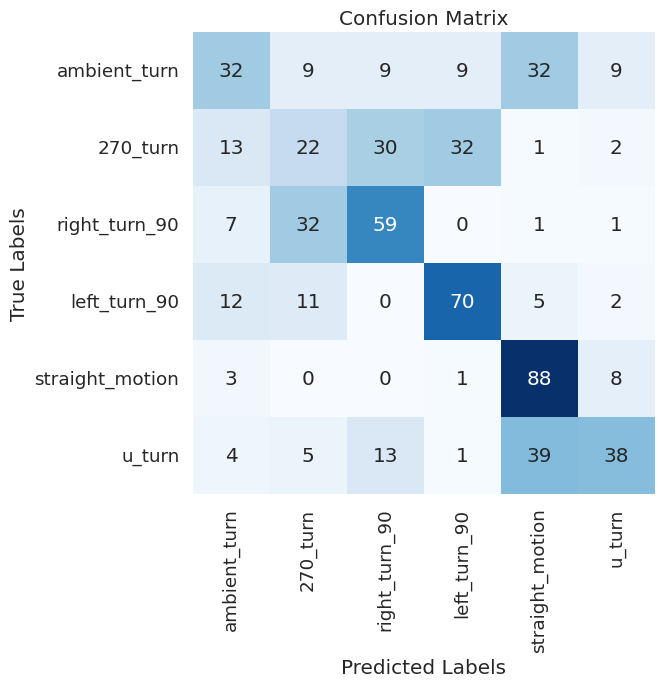

In [7]:
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="euclidean")
knn_clf.fit(ts_X_train, ts_Y_train)
predicted_labels = knn_clf.predict(ts_X_val)

# plot the confusion matrix
cm = confusion_matrix(ts_Y_val, predicted_labels)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

print(accuracy_score(ts_Y_val, predicted_labels))
plot_confusion_matrix(cm, class_labels)

Try binary classification

In [ ]:
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
knn_clf.fit(ts_X_train, ts_Y_train)
predicted_labels = knn_clf.predict(ts_X_val)

# plot the confusion matrix
cm = confusion_matrix(ts_Y_val, predicted_labels)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

print(accuracy_score(ts_Y_val, predicted_labels))
plot_confusion_matrix(cm, class_labels)

In [70]:
def predict_accuracy(n_clusters, k):
    training_directory = '/home/tyler/Documents/Matt3r/imu-classification/DATA/standardized/stage5_standartized/train'
    validation_directory = '/home/tyler/Documents/Matt3r/imu-classification/DATA/standardized/stage5_standartized/val'
    TRAIN_SAMPLES_PER_CLASS = 100
    VAL_SAMPLES_PER_CLASS = 100

    ts_X_train, ts_Y_train, class_labels = get_data(validation_directory, TRAIN_SAMPLES_PER_CLASS, n_clusters, train=True)
    ts_X_val, ts_Y_val, _ = get_data(training_directory, VAL_SAMPLES_PER_CLASS)

    knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw")
    knn_clf.fit(ts_X_train, ts_Y_train)
    predicted_labels = knn_clf.predict(ts_X_val)

    return n_clusters, k, ts_Y_val, predicted_labels, accuracy_score(ts_Y_val, predicted_labels)

tests = []
clusters_tests = [1,2,3,4,5,6,7,8,9,10,25,50]
k_tests = [1,3,4,5,6,7,8,9,10]
for n in clusters_tests:
    for k in k_tests:
        if k <= n:
            result = predict_accuracy(n, k)
            tests.append(result)
            print(f'n={n}, k={k}, accuracy={result[4]}')

n=1, k=1, accuracy=0.54
n=2, k=1, accuracy=0.5366666666666666
n=3, k=1, accuracy=0.5216666666666666
n=3, k=3, accuracy=0.37166666666666665
n=4, k=1, accuracy=0.5316666666666666
n=4, k=3, accuracy=0.35333333333333333
n=4, k=4, accuracy=0.30833333333333335
n=5, k=1, accuracy=0.45666666666666667
n=5, k=3, accuracy=0.4866666666666667
n=5, k=4, accuracy=0.5133333333333333
n=5, k=5, accuracy=0.43166666666666664
n=6, k=1, accuracy=0.52
n=6, k=3, accuracy=0.40166666666666667
n=6, k=4, accuracy=0.49166666666666664
n=6, k=5, accuracy=0.43833333333333335
n=6, k=6, accuracy=0.455
n=7, k=1, accuracy=0.4816666666666667
n=7, k=3, accuracy=0.4216666666666667
n=7, k=4, accuracy=0.48333333333333334
n=7, k=5, accuracy=0.48
n=7, k=6, accuracy=0.42
n=7, k=7, accuracy=0.495
n=8, k=1, accuracy=0.4766666666666667
n=8, k=3, accuracy=0.4166666666666667
n=8, k=4, accuracy=0.5283333333333333
n=8, k=5, accuracy=0.465
n=8, k=6, accuracy=0.525
n=8, k=7, accuracy=0.47833333333333333
n=8, k=8, accuracy=0.4766666666666